#### Build a simple workflow or graph using LangGraph

#### State

In [14]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [15]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [18]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [23]:
from langchain_groq import ChatGroq

llm_groq= ChatGroq(model="deepseek-r1-distill-llama-70b")
print(llm_groq.invoke("Hi"));

content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 4, 'total_tokens': 20, 'completion_time': 0.08055101, 'prompt_time': 0.002070283, 'queue_time': 0.20663020699999998, 'total_time': 0.082621293}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None} id='run--a3e9cb89-bdf2-4d12-a319-b7e679af7f0d-0' usage_metadata={'input_tokens': 4, 'output_tokens': 16, 'total_tokens': 20}


In [43]:
import requests
from langgraph.graph import StateGraph, END
from transformers import pipeline
from typing import TypedDict, Optional
from transformers import pipeline, AutoTokenizer

model_name = "sshleifer/distilbart-cnn-12-6"
summarizer = pipeline("summarization", model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
def summarize_diff_node(state: PRState) -> PRState:
    diff = state["diff"]
    
    # Tokenize and truncate to 1024 tokens
    tokens = tokenizer(diff, return_tensors="pt", truncation=True, max_length=1024)
    input_text = tokenizer.decode(tokens["input_ids"][0], skip_special_tokens=True)

    summary = summarizer(input_text, max_length=150, min_length=30, do_sample=False)[0]["summary_text"]
    return {"summary": summary}

# Hugging Face summarization model
class PRState(TypedDict):
    pr_url: str
    diff: Optional[str]
    summary: Optional[str]

# Tool: fetch PR diff from GitHub
def fetch_pr_diff(pr_url: str) -> str:
    if "github.com" not in pr_url or "/pull/" not in pr_url:
        raise ValueError("Invalid GitHub PR URL")
    
    pr_api_url = pr_url.replace("github.com", "api.github.com/repos").replace("/pull/", "/pulls/")
    diff_url = pr_api_url + ".diff"
    
    response = requests.get(diff_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch diff: {response.status_code}")
    
    return response.text[:5000]  # Limit for summarizer

# Node: FetchPR
def fetch_pr_node(state: PRState) -> PRState:
    pr_url = state["pr_url"]
    diff = fetch_pr_diff(pr_url)
    return {"pr_url": pr_url, "diff": diff}  # 👈 Include pr_url to preserve state



# Create LangGraph Agent
def build_agent():
    builder = StateGraph(PRState)  # 👈 set schema here

    builder.add_node("FetchPR", fetch_pr_node)
    builder.add_node("SummarizeDiff", summarize_diff_node)

    builder.set_entry_point("FetchPR")
    builder.add_edge("FetchPR", "SummarizeDiff")
    builder.add_edge("SummarizeDiff", END)

    return builder.compile()

# Build the agent
agent = build_agent()

# Provide PR URL
input_state = {
    "pr_url": "https://github.com/craftista/craftista/pull/11"  # Replace with real PR URL
}

# Run the agent
final_state = agent.invoke(input_state)

# Print the summary
print("Summary of PR diff:")
print(final_state["summary"])


Device set to use cpu


Summary of PR diff:
 User's view has been added to a yaml file on GitHub's pull request page . The code is available to download and use for the latest version of the app .


Device set to use cpu


Generated summary:  User's view has been added to a yaml file on GitHub's pull request page . The code is available to download and use for the latest version of the app .
{'id': '246896', 'key': 'BURQ-997', 'self': 'https://folio3.atlassian.net/rest/api/3/issue/246896'}
{'ticket_id': 'BURQ-997', 'pr_url': 'https://github.com/craftista/craftista/pull/11', 'diff': '{"url":"https://api.github.com/repos/craftista/craftista/pulls/11","id":1995565081,"node_id":"PR_kwDOKfSwHc528egZ","html_url":"https://github.com/craftista/craftista/pull/11","diff_url":"https://github.com/craftista/craftista/pull/11.diff","patch_url":"https://github.com/craftista/craftista/pull/11.patch","issue_url":"https://api.github.com/repos/craftista/craftista/issues/11","number":11,"state":"open","locked":false,"title":"Feature x","user":{"login":"mohitthakur9901","id":116665336,"node_id":"U_kgDOBvQr-A","avatar_url":"https://avatars.githubusercontent.com/u/116665336?v=4","gravatar_id":"","url":"https://api.github.com/u

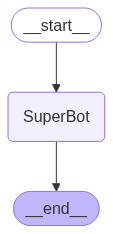

In [ ]:
import requests
from langgraph.graph import StateGraph, END
from transformers import pipeline
from typing import TypedDict, Optional
from transformers import pipeline, AutoTokenizer
import json
from requests.auth import HTTPBasicAuth

model_name = "sshleifer/distilbart-cnn-12-6"
summarizer = pipeline("summarization", model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def summarize_diff_node(state: PRState) -> PRState:
    diff = state["diff"]
    
    # Tokenize and truncate to 1024 tokens
    tokens = tokenizer(diff, return_tensors="pt", truncation=True, max_length=1024)
    input_text = tokenizer.decode(tokens["input_ids"][0], skip_special_tokens=True)

    summary = summarizer(input_text, max_length=150, min_length=30, do_sample=False)[0]["summary_text"]
    
    print(f"Generated summary: {summary}")  # Debugging output to check summary
    
    return {"summary": summary}


# Hugging Face summarization model
class PRState(TypedDict):
    ticket_id:str
    pr_url: str
    diff: Optional[str]
    summary: Optional[str]

# Tool: fetch PR diff from GitHub
def fetch_pr_diff(pr_url: str) -> str:
    if "github.com" not in pr_url or "/pull/" not in pr_url:
        raise ValueError("Invalid GitHub PR URL")
    
    pr_api_url = pr_url.replace("github.com", "api.github.com/repos").replace("/pull/", "/pulls/")
    diff_url = pr_api_url + ".diff"
    
    response = requests.get(diff_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch diff: {response.status_code}")
    
    return response.text[:5000]  # Limit for summarizer

# Node: FetchPR
def fetch_pr_node(state: PRState) -> PRState:
    pr_url = state["pr_url"]
    diff = fetch_pr_diff(pr_url)
    return {"pr_url": pr_url, "diff": diff}  # 👈 Include pr_url to preserve state

##Jira Integration: Create Ticket
def create_jira_ticket(state: PRState) -> str:
    summary = state["summary"]  # Get the summary passed from the previous node
    
    # Check if summary is valid
    if not summary or not isinstance(summary, str):
        raise ValueError("Summary must be a valid non-empty string")
    # Jira API URL and Credentials
    jira_domain = "folio3.atlassian.net"  # Correct Jira domain format
    auth_email = "salmanferoz@folio3.com"  # Your Jira email
    auth_token = ""  # Your Jira API token
    project_key = "BURQ"  # Your Jira project key
    
    # Jira API endpoint to create issue
    url = f"https://{jira_domain}/rest/api/3/issue"
    
    # Jira Issue Payload with ADF format for description
    payload = {
        "fields": {
            "project": {"key": project_key},
            "summary": summary,
            "description": {
                "type": "doc",
                "version": 1,
                "content": [
                    {
                        "type": "paragraph",
                        "content": [
                            {
                                "type": "text",
                                "text": summary  # Use summary in the description (as a simple text block)
                            }
                        ]
                    }
                ]
            },
            "issuetype": {"name": "Task"}
        }
    }
    
    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json"
    }
    
    response = requests.post(
        url,
        headers=headers,
        data=json.dumps(payload),
        auth=HTTPBasicAuth(auth_email, auth_token)
    )
    print(response.json())
    if response.status_code == 201:
        ticket_id = response.json()['key']
        return {"ticket_id": ticket_id, "summary": summary}  # Return a dictionary with ticket_id and summary
    else:
        raise Exception(f"Failed to create Jira ticket: {response.status_code}, {response.text}")

   
# Create LangGraph Agent
def build_agent():
    builder = StateGraph(PRState)  # 👈 set schema here

    # Add Nodes to the Graph
    builder.add_node("FetchPR", fetch_pr_node)  # Using fetch_pr_node instead of fetch_pr_diff
    builder.add_node("SummarizeDiff", summarize_diff_node)
    builder.add_node("CreateJiraTicket", create_jira_ticket)

    # Set the Entry Point and Flow
    builder.set_entry_point("FetchPR")
    builder.add_edge("FetchPR", "SummarizeDiff")
    builder.add_edge("SummarizeDiff", "CreateJiraTicket")
    builder.add_edge("CreateJiraTicket", END)

    return builder.compile()  # Ensure it returns the compiled agent

# Build the agent
agent = build_agent()

# Check if agent is successfully created
if agent is not None:
    # Provide PR URL
    input_state = {
        "pr_url": "https://github.com/craftista/craftista/pull/11"  # Replace with real PR URL
    }

    # Run the agent
    final_state = agent.invoke(input_state)
    print(final_state)
    # Print the summary
    print(f"Summary of PR diff:\n{final_state['summary']}")
    print(f"Created Jira Ticket: {final_state['ticket_id']}")
else:
    print("Failed to build the agent")
    ## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))


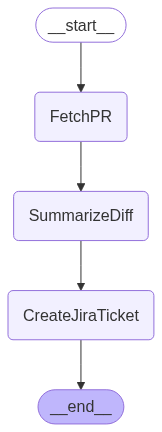

In [77]:
from IPython.display import Image, display
# Display the Mermaid diagram as PNG
graph = agent.get_graph()
png_data = graph.draw_mermaid_png()
display(Image(data=png_data))